In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

#Set your SERPER_API_KEY for goolge search tool and OPENAI_API_KEY in .env for openai api.

import warnings
warnings.filterwarnings("ignore")


from langchain_visualizer.jupyter import visualize
import asyncio
#The visualizer is for tracing the prompt messages in detail and debug. 

In [2]:
# used for vpn setting. 
# os.environ['http_proxy'] = "http://127.0.0.1:7890" 
# os.environ['https_proxy'] = "https://127.0.0.1:7890" 
# import requests
# requests.get("https://google.com")

In [3]:
import json
import pandas as pd
import re
from tqdm.auto import tqdm
from typing import List, Union
import zipfile
from IPython.display import display, Markdown

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain import OpenAI, LLMChain

from langchain.prompts import BaseChatPromptTemplate, ChatPromptTemplate, PromptTemplate

from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationSummaryMemory, ChatMessageHistory

from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType

from langchain.tools import HumanInputRun
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
from langchain.vectorstores import Pinecone

from langchain.utilities import GoogleSerperAPIWrapper
from langchain.tools.python.tool import PythonREPLTool

In [5]:
llm = OpenAI(temperature=0)
# create necessary tools
python_repl = PythonREPLTool()
search = GoogleSerperAPIWrapper()
human = HumanInputRun()
# You can create the tool to pass to an agent
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run
)
google_serp = Tool(
        name="search",
        func=search.run,
        description="Useful for when you need to ask with search"
    )
human_tool = Tool(
        name="human",
        func=human.run,
        description="useful for when you need to ask for human guidance. Use this tool more often if the question is about data or type of chart."
    )



In [6]:
prompt = PromptTemplate(
input_variables=["query"],
template="{query}"
)

llm_chain = LLMChain(llm=llm, prompt=prompt)

# initialize the LLM tool
llm_tool = Tool(
name='Language Model',
func=llm_chain.run,
description='use this tool for general purpose queries and logic'
)

In [7]:
# Changing the description of tools can influence the agent's priority of using them
#tools = load_tools(["human", "python_repl"], llm=llm)
tools = [
    human_tool,repl_tool,llm_tool, google_serp
]
#tools[0].description = tools[0].description + "Always use this tool first. Show your thought to human first, and then ask questions about specific information. "
#tools.append(google_serp)
#tools[1].description = tools[1].description + "If modules or libraries is missing, ask human for help with instructions. Use fake data if no data input is provided."
#tools[2].description = tools[2].description + "Must include python in the searching keyword."
#print(type(tools[2]))

In [8]:
#Create the prompt. It is hard to get exactly what I want with the instruction in prompt. Still work in process.       
template = """ You are an assistant that only helps with visualization tasks, such as producing figure or chart for certain data.
Have a conversation with human, figure out the data you need to use. 
Then Ask human the type of chart you need to plot with python.
Then provide a python code that produce the chart. 
Try to fix all bugs in the code.
If you can not fix a bug after trying twice, show human the code and ask for help.
Improve the code by asking human for feed back until human is satisfied.
If you encounter some error, identify which line of codes cause the error, and analyze the reason by printing out information that can be 
relevant to the error message. For example, you can print out the columns of data if you encounter 
a key error.
You can search for suggestions and tips, but you should always use a key word as specific as possible.
For example, if you want to produce a bar chart with python, and needs to make it looks better,
search for "python beautiful bar chart tips".
As another example, you can use the entire error message as key word to search for solution.

You have access to the following tools:
{tools}

Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do, and if human said they are satisfied.
Action: the action to take, should be one of [{tool_names}].
Action Input: the input to the action. 
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: Since human is satisfied, I now know the final answer
Final Answer: the final answer to the original input question. Must provide a python code template, as well as the result of executing the code.

Begin! Remember to give detailed, informative answers.

Previous conversation history:
{history}

New question: {input}
{agent_scratchpad}"""


# Set up a prompt template
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]
    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]


    
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps", "history"]
)


In [9]:
class CustomOutputParser(AgentOutputParser):
    
    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        
        # Parse out the action and action input
        regex = r"Action: (.*?)[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        
        # If it can't parse the output it raises an error
        # You can add your own logic here to handle errors in a different way i.e. pass to a human, give a canned response
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)
    
output_parser = CustomOutputParser()

In [10]:
llm_chain = LLMChain(llm=OpenAI(temperature=0), prompt=prompt)
tool_names = [tool.name for tool in tools]
agent = LLMSingleActionAgent(
    llm_chain=llm_chain, 
    output_parser=output_parser,
    stop=["\nObservation:"], 
    allowed_tools=tool_names
)
memory = ConversationBufferMemory(memory_key="history")
#memory = ConversationBufferWindowMemory(k=2)
#memory = ConversationSummaryMemory(llm=OpenAI(temperature=0))
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True, memory=memory,  max_iterations=100,
)


2023-07-18 13:04.10.739479 [info     ] Trace: http://127.0.0.1:8935/traces/01H5MZB6F93X2SW3AJDEY1JRN6


> Entering new AgentExecutor chain...
2023-07-18 13:04.11.090819 [info     ] Starting server, set OUGHT_ICE_AUTO_SERVER=0 to disable.

Thought: I need to ask human for the data and the type of chart they want.
Action: human
Action Input: What data do you have for population distribution in America?

What data do you have for population distribution in America?
2023-07-18 13:04.14.365122 [info     ] Server started! Run `python -m ice.server stop` to stop it.
Rendering http://127.0.0.1:8935/traces/01H5MZB6F93X2SW3AJDEY1JRN6 in notebook


./population.csv


Observation:./population.csv
 I need to ask human what type of chart they want.
Action: human
Action Input: What type of chart do you want for population distribution in America?

What type of chart do you want for population distribution in America?
pie chart


Observation:pie chart
 I need to create a pie chart with python.
Action: python_repl
Action Input: 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./population.csv')

labels = data['State']
sizes = data['Population']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Observation:KeyError('State')
 I need to check the data to see what is causing the error.
Action: python_repl
Action Input: 
import pandas as pd

data = pd.read_csv('./population.csv')
print(data.columns)

Observation:Index(['STATE', 'POPESTIMATE2019', 'lat', 'long'], dtype='object')

 I need to change the labels to the correct column name.
Action: python_repl
Act

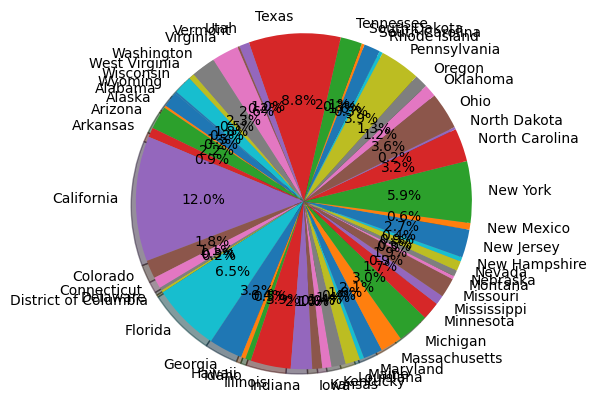



Observation:
 I need to ask human if they are satisfied with the chart.
Action: human
Action Input: Is this the chart you want for population distribution in America?

Is this the chart you want for population distribution in America?
Improve the visualization


Observation:Improve the visualization
 I need to improve the visualization of the chart.
Action: search
Action Input: python beautiful pie chart tips

Observation:Better visualization of Pie charts by MatPlotLib · Always use good colors (preferably light shades) · Change labels, percent label color · Change positions of ... Learn how to make good looking Pie Charts with matplotlib in Python. Change color, order and direction of chart parts. Add percentage-labels and a legend. Missing: tips | Must include:tips. This post describes how to build a pie chart with Python. It starts with basic examples and then describes the most usual customisation like adding proper ... Over 16 examples of Pie Charts including changing color, siz

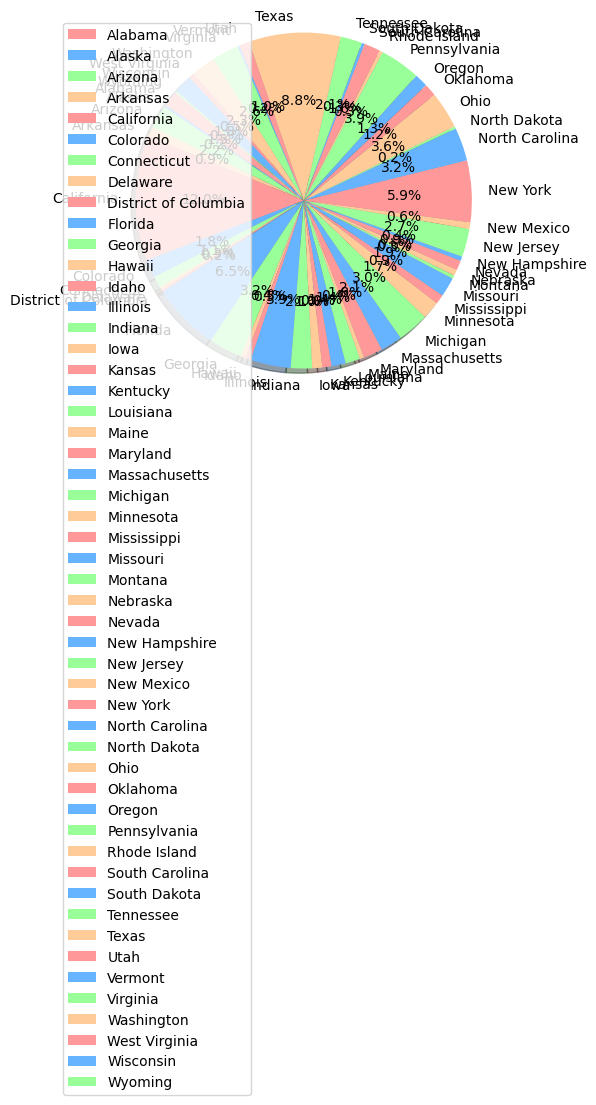



Observation:
 I need to ask human if they are satisfied with the chart.
Action: human
Action Input: Is this the chart you want for population distribution in America?

Is this the chart you want for population distribution in America?
remove the legend, and only show state name and pct for the top 10 states


Observation:remove the legend, and only show state name and pct for the top 10 states


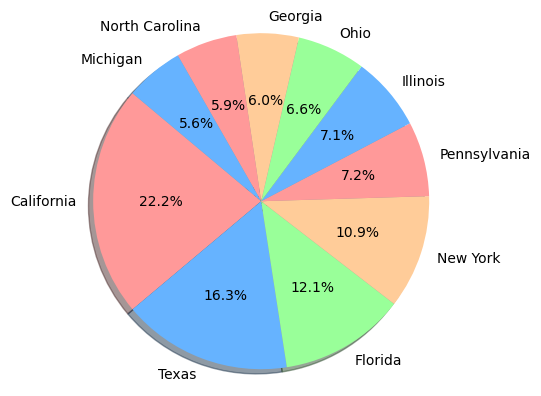

 I need to remove the legend and only show the top 10 states.
Action: python_repl
Action Input: 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./population.csv')

# Sort data by population
data = data.sort_values(by='POPESTIMATE2019', ascending=False)

# Get top 10 states
labels = data['STATE'].head(10)
sizes = data['POPESTIMATE2019'].head(10)

# Use light shades for colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Change labels, percent label color
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.show()

Observation:
 I need to ask human if they are satisfied with the chart.
Action: human
Action Input: Is this the chart you want for population distribution in America?

Is this the chart you want for population distribution in America?
keep all the states in the chart, but only show the annotations for top 10 states


Obse

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/yuanh/miniconda3/envs/chatplot/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/yuanh/miniconda3/envs/chatplot/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yuanh/miniconda3/envs/chatplot/lib/python3.9/site-packages/langchain_visualizer/visualize.py", line 69, in visualize
    return new_main(recipe, fn)
  File "/Users/yuanh/miniconda3/envs/chatplot/lib/python3.9/site-packages/langchain_visualizer/visualize.py", line 67, in new_main
    cli()
  File "/Users/yuanh/miniconda3/envs/chatplot/lib/python3.9/site-packages/langchain_visualizer/visualize.py", line 65, in cli
    asyncio.run(untraced_wrapper(*args, **kwargs))
  File "/Users/yuanh/miniconda3/envs/chatplot/lib/python3.9/site-packages/nest_asyncio.py", line 35, in run
    return loop.run_until_complete(task)
  File "/Users/yuanh/miniconda3/envs/chatplot/

In [11]:
# display(Markdown(agent_executor.run(
#        # "Can you help me name a cat?"
#        "Can you help me create a chart for population distribution in America?"
#     )))

# Use the following code to debug with visualize. 

async def search_agent_demo():
   return agent_executor.run(
      "Can you help me create a chart for population distribution in America?"
   )

visualize(search_agent_demo)